In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score,classification_report, roc_curve
import os
from sklearn.model_selection import  RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import pickle
import shap

# Importação

In [ ]:
# 1. Especifique o caminho para a pasta onde seus arquivos CSV estão localizados.
caminho_da_pasta = 'dados/train_test'

# Cria um dicionário vazio para armazenar os DataFrames
dados = {}

# Lista todos os arquivos na pasta especificada
try:
    lista_de_arquivos = os.listdir(caminho_da_pasta)

    # Itera sobre cada arquivo encontrado na pasta
    for arquivo in lista_de_arquivos:
        # Verifica se o arquivo é um .csv
        if arquivo.endswith('.csv'):
            # Cria o nome da "variável" (que será a chave do dicionário) removendo a extensão .csv
            nome_variavel = os.path.splitext(arquivo)[0]
            
            # Constrói o caminho completo para o arquivo
            caminho_completo = os.path.join(caminho_da_pasta, arquivo)
            
            # Carrega o arquivo CSV e o armazena no dicionário
            dados[nome_variavel] = pd.read_csv(caminho_completo)
            
            print(f"Arquivo '{arquivo}' carregado com sucesso em dados['{nome_variavel}']")

except FileNotFoundError:
    print(f"Erro: O diretório não foi encontrado em '{caminho_da_pasta}'.")
    print("Por favor, verifique se o caminho está correto e tente novamente.")

## Modelagem Sudeste

### Random Forest

In [27]:
rf = RandomForestClassifier(random_state=42)

In [28]:
# defining the possibilities of hyperparameters that will be tested.
n_estimators = [100, 300, 500]
max_depth = [10, 15, 20]
min_samples_split = [2, 5]
min_samples_leaf = [2, 4]

# Crating param grid.
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

# Random Search for tuning.
cv_rf = RandomizedSearchCV(rf, n_iter=50, cv=10, verbose=1, param_distributions=param_grid,n_jobs = -1)

In [ ]:
# Hyperparameter Tuning.
cv_rf.fit(X_train, y_train)

# Best hyperparameters combination.
best_rf = cv_rf.best_params_

# Random Forest with best hyperparameters combination.
rf = RandomForestClassifier(**best_rf, random_state=42)

#Treinando o algoritmo
model = rf.fit(X_train, y_train)
prob_pos_rf = model.predict_proba(X_test)[:, 1]
y_pred_rf = model.predict(X_test)

print('Random Forest Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_rf)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_rf)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_rf)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_rf)))
#print(classification_report(y_test, y_pred_rf))

#Saving model
pickle.dump(model, open("modelos_hiperparametrizados/rf_sudeste_sub.pkl", 'wb'))


### XGBoost

In [32]:
xgboost = xgb.XGBClassifier()

In [33]:
grid_xgboost = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.05, 0.1]
}

rs_cv_xgboost = RandomizedSearchCV(xgboost,
            grid_xgboost,
            cv=10,
            n_iter=5,
            scoring = 'roc_auc',
            return_train_score = False,
            random_state=42)

In [ ]:
# Hyperparameter Tuning.
rs_cv_xgboost.fit(X_train, y_train)

# Best hyperparameters to XGBoost.
best_xgb = rs_cv_xgboost.best_params_

print(best_xgb)

# XGBoost with best hyperparameters combination.
xgboost = xgb.XGBClassifier(**best_xgb, random_state=42)

xgboost.fit(X_train, y_train)

y_pred_xgboost = xgboost.predict(X_test)
prob_pos_xgboost = xgboost.predict_proba(X_test)[:,1]

print('XGBoost Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_xgboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_xgboost)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_xgboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_xgboost)))

#Saving model
pickle.dump(xgboost, open("modelos_hiperparametrizados/xgboost_sudeste_sub.pkl", 'wb'))

### LightGBM

In [35]:
lgbm = lgb.LGBMClassifier()

In [38]:
rs_params_lgbm = {
        'bagging_fraction': [0.5, 0.8, 1],
        'feature_fraction': (0.5, 0.8, 1),
        #'max_depth': -1, #se limitar o crescimento pelo num_leaves, deixe o max_depth ilimitado (-1). São redundantes.
        'num_leaves': [256, 512],
        'min_data_in_leaf': [90, 120]
        }


rs_cv_lgbm = RandomizedSearchCV(lgbm, param_distributions=rs_params_lgbm, cv = 10, n_iter=50)

In [ ]:
#rodando o search para hiperparametrização
rs_cv_lgbm.fit(X_train, y_train)

# Melhores hiperparametros
best_lgbm = rs_cv_lgbm.best_params_

#treinando o modelo
lgbm = lgb.LGBMClassifier(**best_lgbm, random_state=42)
lgbm.fit(X_train, y_train)

#avaliando a performance
y_pred_lgbm = lgbm.predict(X_test)
prob_pos_lgbm = lgbm.predict_proba(X_test)[:,1]

print('LightGBM Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_lgbm)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_lgbm)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_lgbm)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_lgbm)))

pickle.dump(lgbm, open("modelos_hiperparametrizados/lgbm_sudeste.pkl", 'wb'))

### CatBoost

In [41]:
catboost = CatBoostClassifier()

In [42]:
grid_catboost = {"depth": [3, 5, 7, 9, 10],
                "iterations": [250, 500, 1000],
                "learning_rate": [0.01, 0.03, 0.1],
                "l2_leaf_reg": [1, 3, 10],
                "border_count": [32, 50, 100]
               }

rs_cv_catboost = RandomizedSearchCV(catboost, 
                                    param_distributions=grid_catboost,
                                    cv=10,
                                    n_iter=5, 
                                    verbose=1, 
                                    n_jobs = -1,
                                    scoring = 'roc_auc',
                                    return_train_score = False)

In [ ]:
#rodando o search para hiperparametrização
rs_cv_catboost.fit(X_train, y_train)

# Melhores hiperparametros
best_catb = rs_cv_catboost.best_params_

#treinando o modelo
catboost = CatBoostClassifier(**best_catb, random_state=42)
catboost.fit(X_train, y_train)

#avaliando a performance
y_pred_catboost = catboost.predict(X_test)
prob_pos_catboost = catboost.predict_proba(X_test)[:,1]

print('CatBoost Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_catboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_catboost)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_catboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost)))

### Explicabilidade

In [48]:
#Adjusting SHAP for CatBoost
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

c:\Users\vinic\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


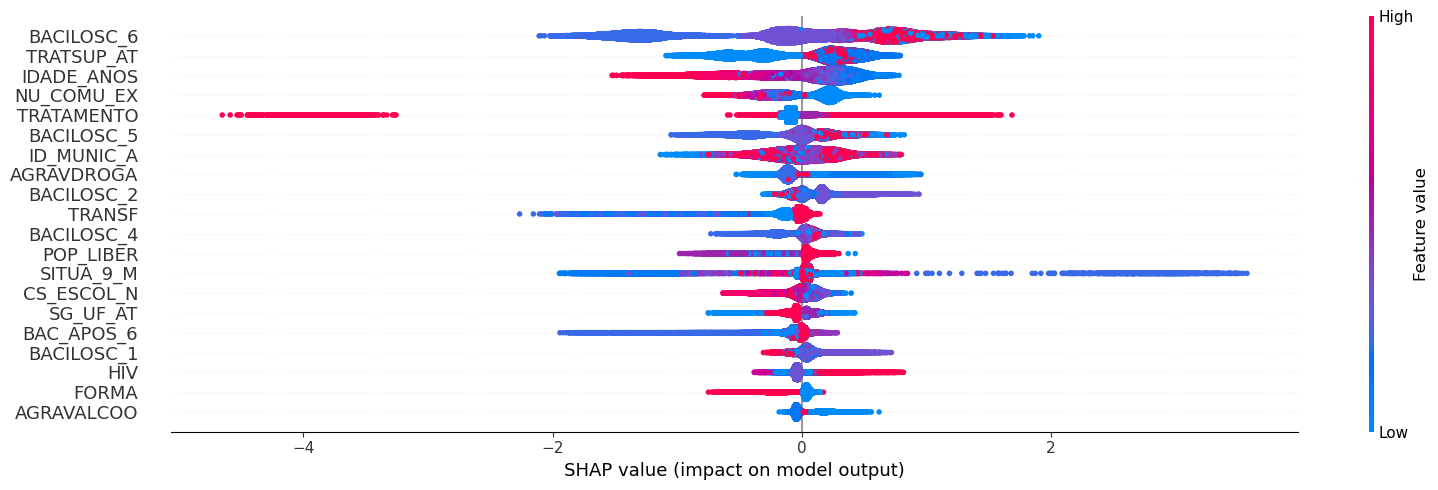

In [49]:
shap.summary_plot(shap_values, X_test, show=False,plot_size=(16, 5))

# Modelagem Automatizada

In [15]:
# --- PREPARAÇÃO PARA O TREINAMENTO AUTOMATIZADO ---

# 1. Identificar as regiões automaticamente a partir das chaves do dicionário 'dados'
#    Ex: extrair 'sudeste' de 'X_train_sudeste'
regioes = ['nordeste', 'norte', 'centro_oeste', 'sudeste', 'sul']
print(f"Regiões encontradas para o treinamento: {regioes}")

# 2. Definir os modelos e seus grids de hiperparâmetros em um só lugar
#    Isso facilita a manutenção e a adição de novos modelos no futuro.

modelos_a_treinar = {
    'RandomForest': {
        'modelo': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 300, 500],
            'max_depth': [10, 15, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [2, 4]
        },
        'n_iter': 50 # Número de iterações para o RandomizedSearchCV
    },
    'XGBoost': {
        'modelo': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 500, 1000],
            'max_depth': [3, 6, 9],
            'eta': [0.01, 0.05, 0.1] # 'eta' é o mesmo que 'learning_rate'
        },
        'n_iter': 5
    },
    'LightGBM': {
        'modelo': lgb.LGBMClassifier(random_state=42),
        'params': {
            'bagging_fraction': [0.5, 0.8, 1.0],
            'feature_fraction': [0.5, 0.8, 1.0],
            'num_leaves': [256, 512],
            'min_data_in_leaf': [90, 120]
        },
        'n_iter': 50
    },
    'CatBoost': {
        'modelo': CatBoostClassifier(random_state=42, verbose=0), # verbose=0 para não poluir o output
        'params': {
            "depth": [3, 5, 7, 9, 10],
            "iterations": [250, 500, 1000],
            "learning_rate": [0.01, 0.03, 0.1],
            "l2_leaf_reg": [1, 3, 10],
            "border_count": [32, 50, 100]
        },
        'n_iter': 5
    }
}

# 3. Criar uma lista para guardar os resultados de todos os modelos e regiões
resultados_gerais = []

# Garante que o diretório para salvar os modelos exista
output_dir = "modelos_hiperparametrizados_v2"
os.makedirs(output_dir, exist_ok=True)
print(f"Diretório para salvar os modelos: '{output_dir}'")

Regiões encontradas para o treinamento: ['nordeste', 'norte', 'centro_oeste', 'sudeste', 'sul']
Diretório para salvar os modelos: 'modelos_hiperparametrizados_v2'


In [16]:
# --- LOOP PRINCIPAL DE TREINAMENTO E AVALIAÇÃO ---

# Loop externo: passa por cada região identificada
for regiao in regioes:
    print(f"\n{'='*60}")
    print(f"INICIANDO TREINAMENTO PARA A REGIÃO: {regiao.upper()}")
    print(f"{'='*60}")

    # Carrega os dados de treino e teste para a região atual
    try:
        X_train = dados[f'X_train_{regiao}']
        y_train = dados[f'y_train_{regiao}']
        X_test = dados[f'X_test_{regiao}']
        y_test = dados[f'y_test_{regiao}']
        
        # Usar .values.ravel() no y_train para evitar avisos de formato
        y_train_flat = y_train.values.ravel()

    except KeyError:
        print(f"AVISO: Não foi possível encontrar o conjunto de dados completo (X/y, train/test) para a região '{regiao}'. Pulando esta região.")
        continue

    # Loop interno: passa por cada modelo definido no dicionário de configuração
    for nome_modelo, config in modelos_a_treinar.items():
        print(f"\n--- Treinando modelo: {nome_modelo} ---")

        # Configura o RandomizedSearchCV para o modelo atual
        rs_cv = RandomizedSearchCV(
            estimator=config['modelo'],
            param_distributions=config['params'],
            n_iter=config['n_iter'],
            cv=10, # Usando 10 folds como no seu exemplo
            scoring='roc_auc',
            verbose=1,
            n_jobs=-1,
            random_state=42
        )

        # Executa a busca por hiperparâmetros
        rs_cv.fit(X_train, y_train_flat)

        # Pega os melhores hiperparâmetros encontrados
        best_params = rs_cv.best_params_
        print(f"Melhores hiperparâmetros para {nome_modelo}: {best_params}")

        # Treina o modelo final com os melhores hiperparâmetros
        modelo_final = config['modelo'].set_params(**best_params)
        modelo_final.fit(X_train, y_train_flat)

        # Faz as predições e calcula as probabilidades
        y_pred = modelo_final.predict(X_test)
        prob_pos = modelo_final.predict_proba(X_test)[:, 1]

        # Calcula as métricas de avaliação
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc = roc_auc_score(y_test, prob_pos)

        # Imprime os resultados para o modelo atual
        print(f"\nResultados de Avaliação para {nome_modelo} na região {regiao.upper()}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  AUC: {auc:.4f}")

        # Salva o dicionário de resultados na lista geral
        resultados_gerais.append({
            'Regiao': regiao,
            'Modelo': nome_modelo,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'AUC': auc,
            'Melhores_Hiperparametros': best_params
        })

        # Salva o modelo treinado em um arquivo .pkl
        nome_arquivo_modelo = f"{nome_modelo.lower()}_{regiao}.pkl"
        caminho_salvar_modelo = os.path.join(output_dir, nome_arquivo_modelo)
        with open(caminho_salvar_modelo, 'wb') as file:
            pickle.dump(modelo_final, file)
        print(f"Modelo salvo em: '{caminho_salvar_modelo}'")

print(f"\n{'='*60}")
print("TODOS OS TREINAMENTOS FORAM CONCLUÍDOS!")
print(f"{'='*60}")


INICIANDO TREINAMENTO PARA A REGIÃO: NORDESTE

--- Treinando modelo: RandomForest ---
Fitting 10 folds for each of 36 candidates, totalling 360 fits


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Melhores hiperparâmetros para RandomForest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}

Resultados de Avaliação para RandomForest na região NORDESTE:
  Accuracy: 0.8785
  Precision: 0.7333
  Recall: 0.0111
  AUC: 0.7421
Modelo salvo em: 'modelos_hiperparametrizados_v2\randomforest_nordeste.pkl'

--- Treinando modelo: XGBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros para XGBoost: {'n_estimators': 100, 'max_depth': 6, 'eta': 0.1}

Resultados de Avaliação para XGBoost na região NORDESTE:
  Accuracy: 0.8780
  Precision: 0.5070
  Recall: 0.1089
  AUC: 0.7599
Modelo salvo em: 'modelos_hiperparametrizados_v2\xgboost_nordeste.pkl'

--- Treinando modelo: LightGBM ---
Fitting 10 folds for each of 36 candidates, totalling 360 fits


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 2314, number of negative: 16597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Melhores hiperparâmetros para RandomForest: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}

Resultados de Avaliação para RandomForest na região NORTE:
  Accuracy: 0.8570
  Precision: 0.5556
  Recall: 0.0195
  AUC: 0.7283
Modelo salvo em: 'modelos_hiperparametrizados_v2\randomforest_norte.pkl'

--- Treinando modelo: XGBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros para XGBoost: {'n_estimators': 100, 'max_depth': 3, 'eta': 0.05}

Resultados de Avaliação para XGBoost na região NORTE:
  Accuracy: 0.8570
  Precision: 0.5200
  Recall: 0.0508
  AUC: 0.7384
Modelo salvo em: 'modelos_hiperparametrizados_v2\xgboost_norte.pkl'

--- Treinando modelo: LightGBM ---
Fitting 10 folds for each of 36 candidates, totalling 360 fits


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 1193, number of negative: 7127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

CatBoostError: You can't change params of fitted model.

In [ ]:
# --- VISUALIZAÇÃO DOS RESULTADOS ---

# Converte a lista de dicionários em um DataFrame do Pandas
df_resultados = pd.DataFrame(resultados_gerais)

# Ordena os resultados por região e depois pela métrica AUC (descendente) para destacar os melhores
df_resultados_sorted = df_resultados.sort_values(by=['Regiao', 'AUC'], ascending=[True, False])

# Exibe o DataFrame com os resultados de todos os modelos e regiões
print("Resultados Consolidados de Todos os Treinamentos:")
display(df_resultados_sorted)

# Você também pode salvar este DataFrame em um arquivo CSV se desejar
# df_resultados_sorted.to_csv('resultados_modelagem.csv', index=False)